**GMDSI_part2_01_pstfrom_pest_setup_b_freyberg_pstfrom_pest_setup__01__** <font color='blue'> **Weights** </font> **`reimagine adventure`** `... conda activate gmdsitut`

In [1]:
import sys ; import os ; import platform ; from pathlib import Path ; import shutil                # ; import herebedragons as hbd
import warnings ; warnings.filterwarnings("ignore") ; import pandas as pd ; import numpy as np     # ; import helpers
import matplotlib.pyplot as plt; import pyemu ; import flopy ; warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
sim_ws1   = tmp_d = Path('E:\\15_REPOS\\00_BETAMI\\97_GMDSI\\models\\monthly_model_files_1lyr_newstress')   ; sim_name = "freyberg_mf6"
sim_ws    = Path("./part2_01c")                                                                             ; sim_ws.mkdir(exist_ok=True) 

In [3]:
shutil.copytree(sim_ws1, sim_ws, dirs_exist_ok=True) ; sim = flopy.mf6.MFSimulation.load(sim_ws=sim_ws,verbosity_level=0) #; sim.set_sim_path(sim_ws) 
sim.run_simulation() ; pyemu.os_utils.run("mf6",cwd=sim_ws) ; pyemu.os_utils.run(r'mp7 freyberg_mp.mpsim', cwd=sim_ws) ;gwf = sim.get_model()

mf6.exe
mp7.exe freyberg_mp.mpsim


<font color='blue'> **OBS_PAR** </font> 

In [4]:
sr = pyemu.helpers.SpatialReference.from_namfile(os.path.join(sim_ws, "freyberg6.nam"),delr=gwf.dis.delr.array, delc=gwf.dis.delc.array); print(sr)
template_ws = os.path.join(sim_ws,"beta_template")      ; start_datetime="1-1-2008"                  # PEST Template
pf = pyemu.utils.PstFrom(original_d=sim_ws, new_d=template_ws, 
                         remove_existing=True, longnames=True, spatial_reference=sr, zero_based=False, start_datetime=start_datetime, echo=False) 

   could not remove start_datetime
xul:0; yul:10000; rotation:0; proj4_str:None; units:meters; lenuni:2; length_multiplier:1.0


In [5]:
pst = pf.build_pst()

noptmax:0, npar_adj:0, nnz_obs:0


In [6]:
pst.parameter_data.head()

,parnme,partrans,parchglim,parval1,parlbnd,parubnd,pargp,scale,offset,dercom


In [7]:
PAR = pf.add_parameters('freyberg6.npf_k_layer1.txt',par_type='grid')        ; hh = pd.read_csv(os.path.join(sim_ws, 'heads.csv'))        
OBS = pf.add_observations('heads.csv',index_cols='time',use_cols=hh.columns.tolist()[1:])

In [8]:
#PAR.head(2) ; # OBS.head(2)

In [9]:
PAR.to_csv (sim_ws/ "01_PAR.csv") ; OBS.to_csv (sim_ws/ "02_OBS.csv") 

<font color='red'> **PEST** </font> 

In [10]:
pf.mod_sys_cmds.append('mf6')       ; pst = pf.build_pst(filename=os.path.join(pf.new_d,'freyberg.pst'),version=2)

noptmax:0, npar_adj:800, nnz_obs:325


In [11]:
pyemu.os_utils.run('pestpp-ies freyberg.pst',cwd=template_ws)  # New Beta path

pestpp-ies.exe freyberg.pst


In [12]:
pst = pyemu.Pst('part2_01_OUT_b/beta_template/freyberg.pst')  

In [13]:
path = 'E:\\15_REPOS\\00_BETAMI\\97_GMDSI\\models\\data'  ; fpath=os.path.join(path,"obstrue.csv")  

In [14]:
trueobs = pd.read_csv(fpath, index_col=0) ; trueobs.to_csv (sim_ws/ "03_trueobs.csv")  #; trueobs.head(2)

In [15]:
OBS1 = OBS.loc[:, ['obsval']]; OBS1.reset_index(drop=True, inplace=True)          ; trueobs.reset_index(drop=True, inplace=True)
df = pd.concat([OBS1[:], trueobs[:]], axis=1); df2 = df.set_index('time')         ; df2.columns = ['Mod_first_OBS', 'location', 'true_OBS']

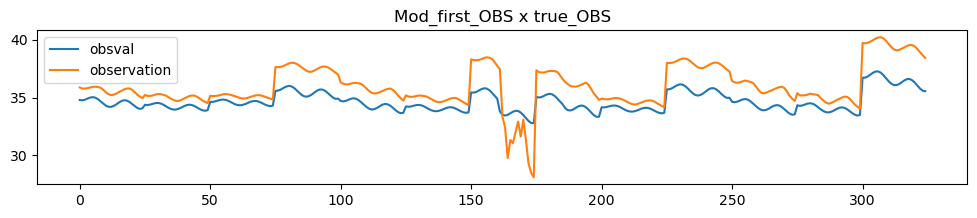

In [16]:
ax = df.plot(use_index=True, y= ['obsval','observation'] , kind="line", rot=0, figsize=(12,2), title='Mod_first_OBS x true_OBS') #; df2.head(2)

In [17]:
obs = pst.observation_data                   # index
for cob in obs.index:
    tmp = obs.loc[cob]   # print(trueobs.loc[(trueobs.time==float(tmp.time))&(trueobs.location==tmp.usecol), 'observation'].values[0])
    obs.loc[cob,'obsval']      = trueobs.loc[(trueobs.time==float(tmp.time))&(trueobs.location==tmp.usecol), 'observation'].values[0] 

<Axes: >

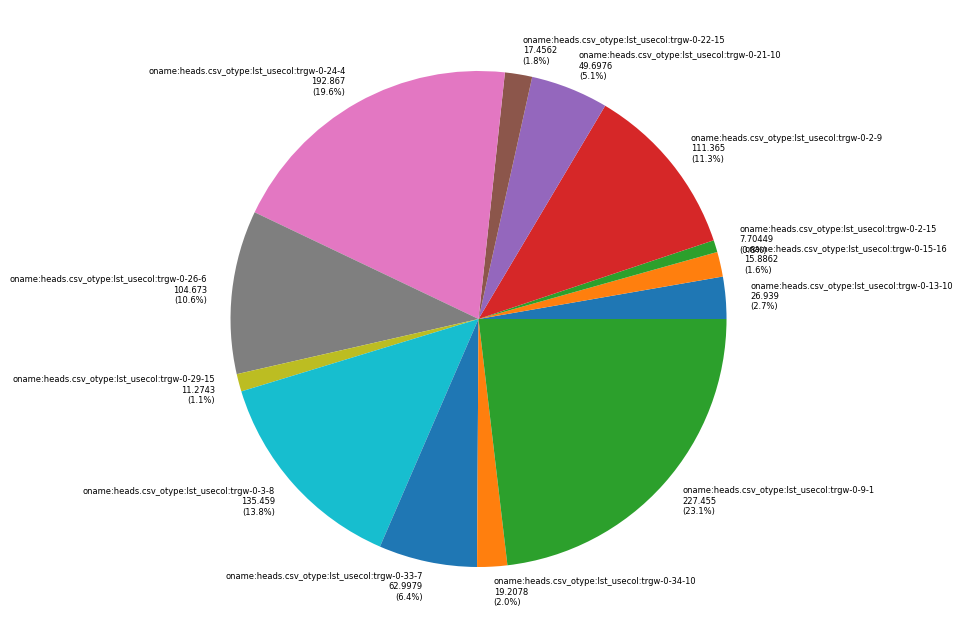

In [18]:
pst.plot(kind='phi_pie')

<Axes: >

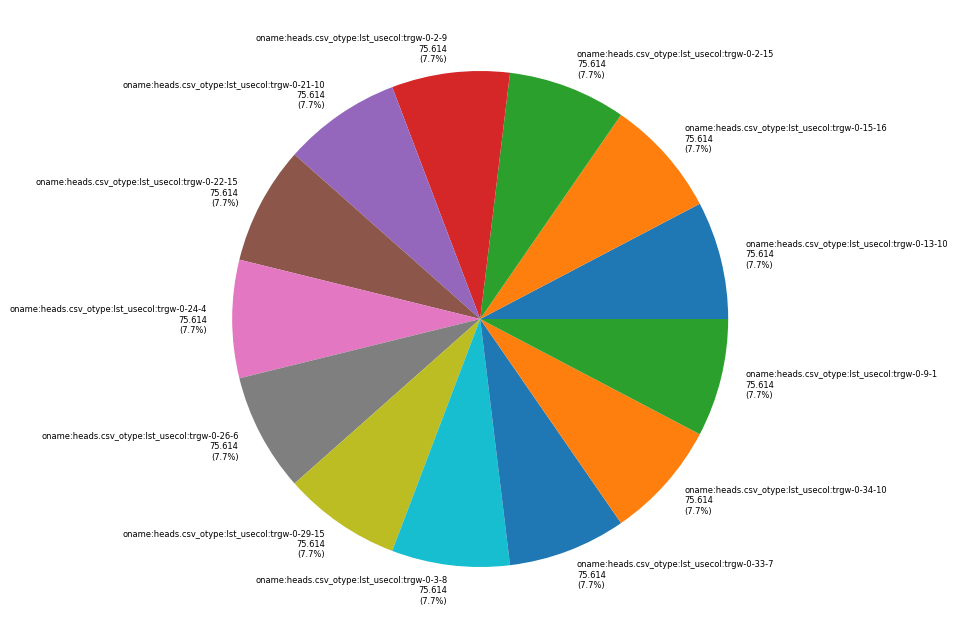

In [19]:
newbalance={grp:1/len(pst.obs_groups)*pst.phi for grp in pst.obs_groups} ;pst.adjust_weights(obsgrp_dict=newbalance)   ;pst.plot(kind='phi_pie')   

In [20]:
OBS_groups = pst.obs_groups

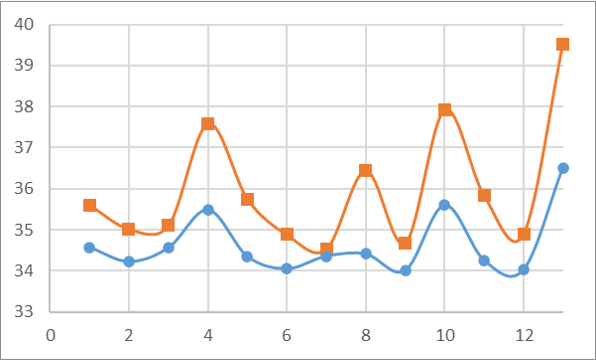

phi (!) 982.9825158606958


In [21]:
# newbalance = {grp:1/len(pst.obs_groups)*pst.phi for grp in pst.obs_groups}
from IPython.display import Image, display ;     
display(Image('E:\\15_REPOS\\00_BETAMI\\97_GMDSI\\_aux\\monthly_heads_xls.png',width = 300, height = 300)); print('phi (!)', pst.phi)

<font color='red'> **_________________RUNNING Parallel____** </font> 

In [22]:
pst.control_data.noptmax=-1  ;   pst.pestpp_options['ies_num_reals']=100

In [23]:
#pst.parameter_data.head(2) 

In [24]:
pst.parameter_data.parlbnd=0.5 ; pst.parameter_data.parubnd=1.5       #; pst.parameter_data.head(2)   

In [25]:
pst.write('part2_01_OUT_b/beta_template/freyberg_prior.pst') 

noptmax:-1, npar_adj:800, nnz_obs:325


In [26]:
#exe_rel_path  = 'E:\\15_REPOS\\00_BETAMI\\97_GMDSI\\00_bin\\pestpp-ies.exe'
#sys.path.insert(0,"models_b")        ; import herebedragons1 as hbd    ; hbd.prep_bins(template_ws)  

In [27]:
pyemu.utils.start_workers('E:\\15_REPOS\\00_BETAMI\\97_GMDSI\\part2_01_OUT_b\\beta_template'  , master_dir='part2_01_OUT_b\\cm_prior', 
                          exe_rel_path='pestpp-ies.exe', pst_rel_path='freyberg_prior.pst'        , worker_root='.'      , num_workers=10)